In [97]:
# Import libraries
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler


In [98]:
# import dataset
columns = ['CRIM', 
           'ZN', 
           'INDUS', 
           'CHAS', 
           'NOX', 
           'RM', 
           'AGE', 
           'DIS', 
           'RAD', 
           'TAX', 
           'PTRATIO', 
           'B', 
           'LSTAT', 
           'MEDV']

df = pd.read_csv('data/housing_dataset.csv', names=columns, delimiter=r"\s+")


## Looking inside the dataframe


In [99]:
df.sample(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
214,0.28955,0.0,10.59,0,0.489,5.412,9.8,3.5875,4,277.0,18.6,348.93,29.55,23.7
11,0.11747,12.5,7.87,0,0.524,6.009,82.9,6.2267,5,311.0,15.2,396.90,13.27,18.9
298,0.06466,70.0,2.24,0,0.400,6.345,20.1,7.8278,5,358.0,14.8,368.24,4.97,22.5
161,1.46336,0.0,19.58,0,0.605,7.489,90.8,1.9709,5,403.0,14.7,374.43,1.73,50.0
275,0.09604,40.0,6.41,0,0.447,6.854,42.8,4.2673,4,254.0,17.6,396.90,2.98,32.0


In [100]:
df.shape

(506, 14)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [102]:
## Uncomment these below lines if you want to see the description of train data

# prof = ProfileReport(df)
# prof.to_file(output_file='train_dataframe_describe.html')

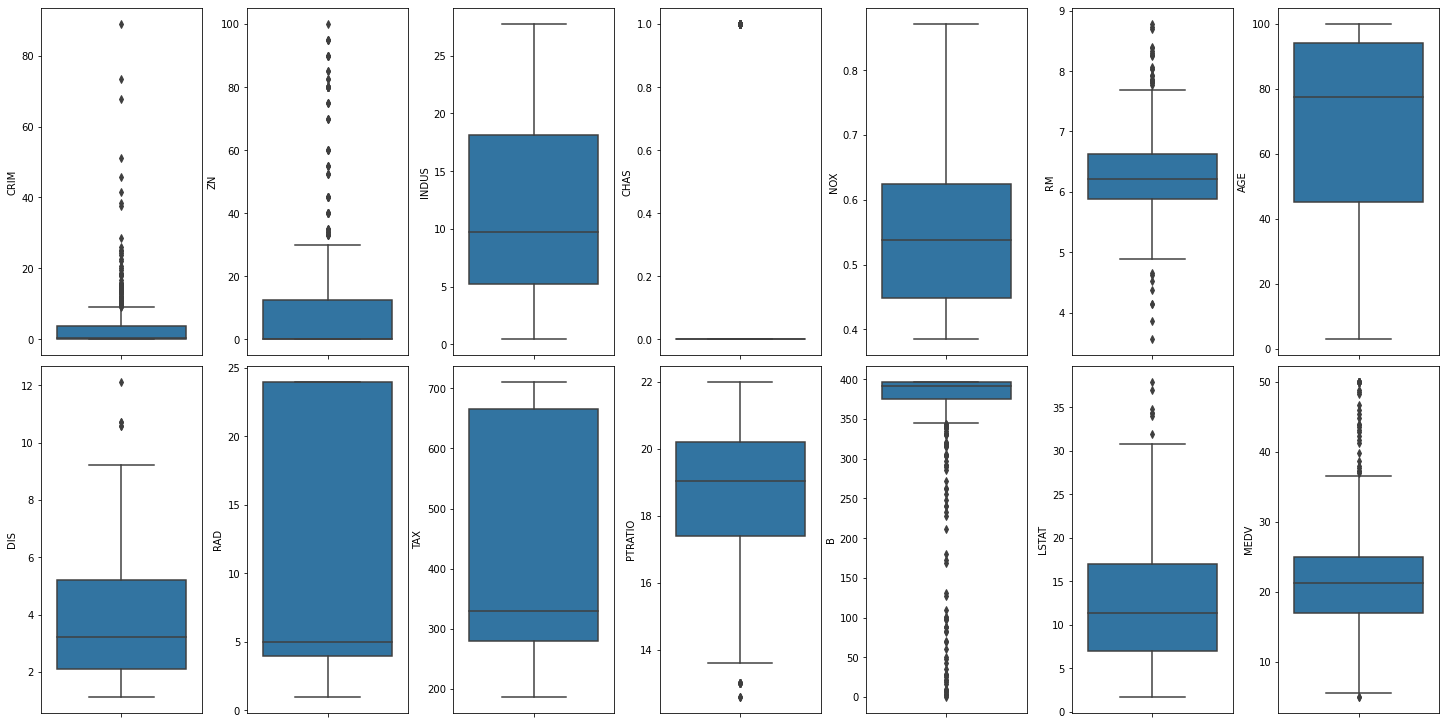

In [103]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()

for k, v in df.items():
    sns.boxplot(y = k, data = df, ax = axs[index])
    index += 1

plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 0.5)

In [113]:
# Finding and cleaning outliers
for k, v in df.items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 13.27%
Column ZN outliers = 13.27%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 4.69%
Column AGE outliers = 0.00%
Column DIS outliers = 1.02%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.65%
Column B outliers = 15.92%
Column LSTAT outliers = 1.43%
Column MEDV outliers = 4.49%


In [104]:
df = df[~(df["MEDV"] >= 50.0)]
print(df.shape)

(490, 14)


In [105]:
mm_scaler = MinMaxScaler()

column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
X = pd.DataFrame(data=mm_scaler.fit_transform(df.loc[:,column_sels]), columns=column_sels)
y = df['MEDV']

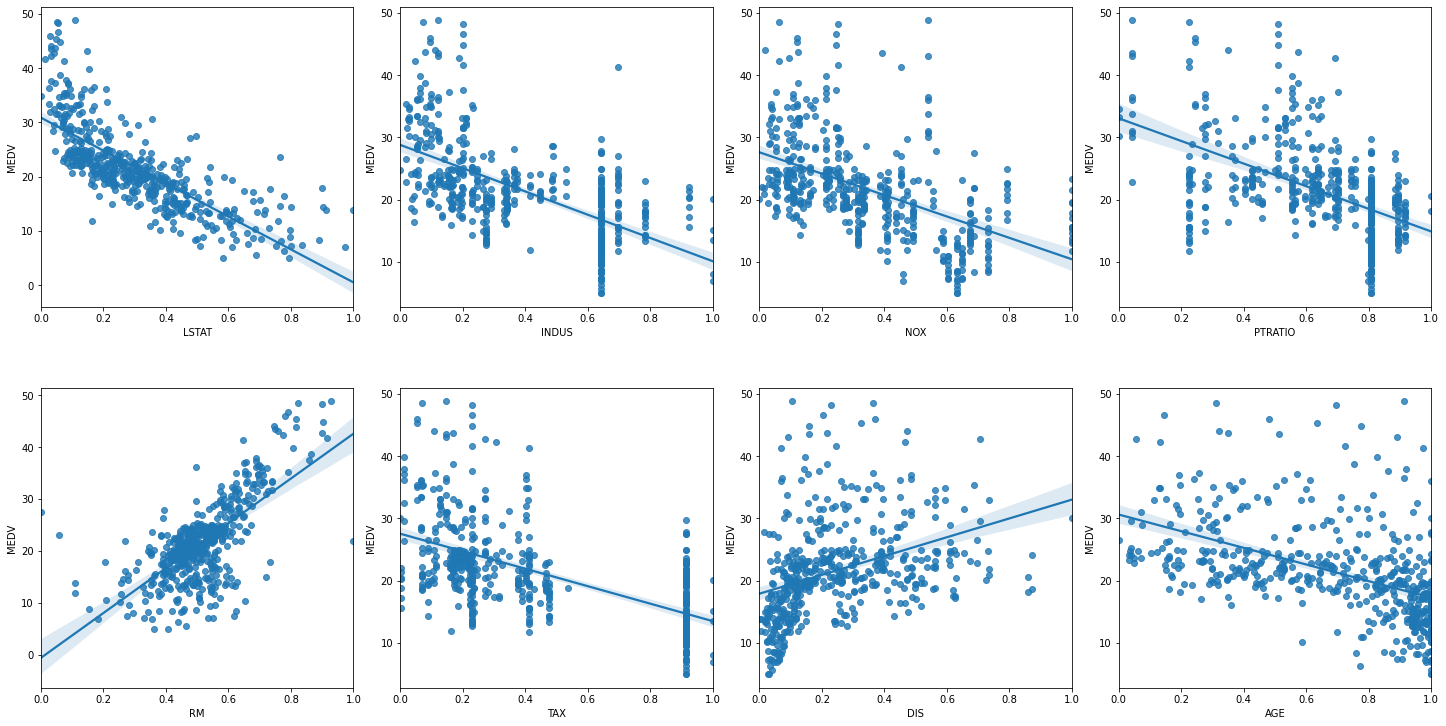

In [106]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=X[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [107]:
# Remove the skewness of the data trough log transformation
y =  np.log1p(y)
for col in X.columns:
    if np.abs(X[col].skew()) > 0.3:
        X[col] = np.log1p(X[col])

## Prediction

In [108]:
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [109]:
scores_map = {}
kf = KFold(n_splits=10)

### Linear model

In [110]:
linear_model = LinearRegression()
scores = cross_val_score(linear_model, 
                          X,
                          y,
                          cv = kf, 
                          scoring = 'neg_mean_squared_error')
 
print("MSE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores_map['LinearRegression'] = scores

MSE: -0.0403 (+/- 0.0395)


In [111]:
# Ridge Model
ridge_model = Ridge()
scores = cross_val_score(ridge_model, 
                          X, 
                          y, 
                          cv = kf, 
                          scoring= 'neg_mean_squared_error')
 
print("MSE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores_map['Ridge'] = scores

MSE: -0.0396 (+/- 0.0390)


In [112]:
# Polynomial Model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_ridge_model = make_pipeline(PolynomialFeatures(degree=3), ridge_model)

scores = cross_val_score(poly_ridge_model,
                         X,
                         y,
                         cv = kf,
                         scoring= 'neg_mean_squared_error')

print("MSE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores_map['PolyRidge'] = scores


MSE: -0.0335 (+/- 0.0307)


In [94]:
# SVM Model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_model = SVR(kernel = 'rbf', C = 1e3, gamma = 0.1)

grid_svm = GridSearchCV(svr_model,
                        cv = kf,
                        param_grid={
                            "C": [1e0, 1e2, 1e3],
                            "gamma": np.logspace(-2, 2, 5)},
                        scoring='neg_mean_squared_error')
grid_svm.fit(X, y)
print("Best Classifier:", grid_svm.best_estimator_)



scores = cross_val_score(svr_model,
                         X,
                         y,
                         cv = kf,
                         scoring='neg_mean_squared_error')

scores_map['SVR'] = scores
print("MSE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Best Classifier: SVR(gamma=1.0)
MSE: -0.0373 (+/- 0.0325)


In [95]:
# Decison Tree model
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(max_depth=4)

grid_dt = GridSearchCV(dt_model,
                       cv = kf,
                       param_grid={
                           "max_depth": [1,2,3,4,5,6,7,8,9,10]},
                       scoring='neg_mean_squared_error')
grid_dt.fit(X, y)

print("Best Decision Tree Model:", grid_dt.best_estimator_)



scores = cross_val_score(dt_model,
                         X,
                         y,
                         cv = kf,
                         scoring= 'neg_mean_squared_error')

scores_map['DecisionTree'] = scores
print("MSE: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))


Best Decision Tree Model: DecisionTreeRegressor(max_depth=4)
MSE: -0.0441 (+/- 0.0327)


In [96]:
# K-Neighbor Regressor
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
grid_knr = GridSearchCV(knn, cv=kf, param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
grid_knr.fit(X, y)
print("Best K-Neighbor Regressor :", grid_knr.best_estimator_)
print("KNN Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))


Best K-Neighbor Regressor : KNeighborsRegressor(n_neighbors=6)
KNN Accuracy: -0.0435 (+/- 0.0280)
